In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from zodipy._source_funcs import get_phase_function
from zodipy.source_params import PHASE_FUNCTION_DIRBE, SPECTRUM_DIRBE

from zodipol.mie_scattering.particle_size_model import ParticleSizeModel
from zodipol.mie_scattering.mie_scattering_model import MieScatteringModel
from zodipol.visualization.mie_plotting import plot_mueller_matrix_elems
from zodipol.zodipol.zodipol import MIE_MODEL_DEFAULT_PATH

In [14]:
wavelength = SPECTRUM_DIRBE[:3].to('nm').value  # in nm
C = list(zip(*PHASE_FUNCTION_DIRBE))[:3]
C_w = dict(zip(wavelength.round().astype(int), C))
C_w = {1250: C_w[1250]}

In [23]:

def distance_from_kelsall(theta, func, c):
    kelsall_125um = get_phase_function(theta, c)
    bhat = bhat_distance(theta, func, kelsall_125um)
    return bhat


def bhat_distance(theta, func1, func2):
    bhat_distance = -np.log(2*np.pi*np.trapz(np.sqrt(func1 * func2) * np.sin(theta), theta))
    return bhat_distance


def scattering_dop(mueller):
    return np.max(abs(mueller[..., 0, 1] / mueller[..., 0, 0]))


def optimization_cost(s_min, s_max, big_gamma, small_gamma):
    psm = ParticleSizeModel(s_min=s_min, s_max=s_max, big_gamma=big_gamma, small_gamma=small_gamma, s_res=200)  # create a particle size model
    mie = MieScatteringModel.train(spectrum, particle_size=psm)  # train a Mie scattering model

    # plot the model
    dop = []
    dist_from_kesall = []
    for w in C_w:
        mueller_125um = mie.get_mueller_matrix(np.array(w), theta)  # get the scattering
        mie_phase_func_125um = mueller_125um[..., 0, 0, 0]
        cur_dist_from_kesall = distance_from_kelsall(theta, mie_phase_func_125um, c=C_w[w])
        dist_from_kesall.append(cur_dist_from_kesall)
        dop.append(scattering_dop(mueller_125um))

    mean_dist = np.mean(dist_from_kesall)
    return mean_dist, np.mean(dop)

In [16]:
spectrum = np.logspace(np.log10(300), np.log10(3500), 10)  # white light wavelength in nm
theta = np.linspace(0, np.pi, 100)  # angle in radians

# create a parameter mapping
s_min = np.logspace(np.log10(0.001), np.log10(1), 5)  # in um
s_max = np.logspace(np.log10(20), np.log10(100), 5)  # in um
big_gamma = np.arange(5.2, 5.6, 0.2)
small_gamma = np.arange(3.5, 4.5, 0.5)
BG, SG, SN, SX = np.meshgrid(big_gamma, small_gamma, s_min, s_max)  # create a grid of parameters
SN, SX, BG, SG = SN.flatten(), SX.flatten(), BG.flatten(), SG.flatten()  # flatten the grid

In [17]:
parameter_mapping = pd.DataFrame({'s_min': SN, 's_max': SX, 'big_gamma': BG, 'small_gamma': SG})  # create a dataframe from the grid
print(f'Number of models to train: {len(parameter_mapping)}')
parameter_mapping  # show the dataframe

Number of models to train: 100


,s_min,s_max,big_gamma,small_gamma
0,0.001,20.000000,5.2,3.5
1,0.001,29.906976,5.2,3.5
2,0.001,44.721360,5.2,3.5
3,0.001,66.874030,5.2,3.5
4,0.001,100.000000,5.2,3.5
...,...,...,...,...
95,1.000,20.000000,5.4,4.0
96,1.000,29.906976,5.4,4.0
97,1.000,44.721360,5.4,4.0
98,1.000,66.874030,5.4,4.0


In [25]:
iterator = tqdm(parameter_mapping.iterrows(), total=len(parameter_mapping))
results = []
for ind, row in iterator:
    # create a Mie scattering model
    dist_kelsall, polariz = optimization_cost(s_min=row['s_min'], s_max=row['s_max'], big_gamma=row['big_gamma'],
                            small_gamma=row['small_gamma'])

    row_dict = row.to_dict()
    row_dict['dist_from_kesall'] = dist_kelsall
    row_dict['polarization'] = polariz
    results.append(row_dict)
    iterator.set_description(", ".join([f"{k}: {row_dict[k]: .3f}" for k in row_dict]))

s_min:  0.032, s_max:  20.000, big_gamma:  5.200, small_gamma:  4.000, dist_from_kesall: -0.434, polarization:  0.994:  61%|██████    | 61/100 [1:24:23<37:12, 57.25s/it]   Process ForkPoolWorker-828:
Process ForkPoolWorker-820:
Process ForkPoolWorker-827:
Process ForkPoolWorker-824:
Process ForkPoolWorker-825:
Process ForkPoolWorker-817:
Process ForkPoolWorker-818:
Process ForkPoolWorker-819:
Process ForkPoolWorker-826:
Process ForkPoolWorker-823:
Process ForkPoolWorker-822:
Process ForkPoolWorker-821:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/oravi/miniconda3/envs/zodiacal-polarized/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/oravi/miniconda3/envs/zodiacal-polarized/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/oravi/miniconda3/envs/zodiacal-polarized/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3963/3698868108.py", line 5, in <module>
    dist_kelsall, polariz = optimization_cost(s_min=row['s_min'], s_max=row['s_max'], big_gamma=row['big_gamma'],
  File "/tmp/ipykernel_3963/3799074117.py", line 18, in optimization_cost
    mie = MieScatteringModel.train(spectrum, particle_size=psm)  # train a Mie scattering model
  File "/mnt/d/CodingProjects/zodiacal-polarized/zodipol/mie_scattering/mie_scattering_model.py", line 40, in train
    S1, S2 = cls._calculate_S1S2(x, refractive_index, mu, particle_likelihood, refractive_index_weight)
  File "/mnt/d/CodingProjects/zodiacal-polarized/zodipol/mie_scattering/mie_scattering_model.py", line 142, in _calculate_S1S2
  File "/mnt/d/CodingProjects/zodiacal-polarized/zodipol/mie_scattering/m

In [32]:
results_df = pd.DataFrame(results)
results_df.dist_from_kesall = -results_df.dist_from_kesall
results_df

,s_min,s_max,big_gamma,small_gamma,dist_from_kesall,polarization
0,0.001000,20.000000,5.2,3.5,0.658609,0.985311
1,0.001000,29.906976,5.2,3.5,0.663427,0.985337
2,0.001000,44.721360,5.2,3.5,0.664646,0.985225
3,0.001000,66.874030,5.2,3.5,0.665154,0.985330
4,0.001000,100.000000,5.2,3.5,0.665009,0.985360
...,...,...,...,...,...,...
56,0.005623,29.906976,5.2,4.0,0.342620,0.997321
57,0.005623,44.721360,5.2,4.0,0.342449,0.997328
58,0.005623,66.874030,5.2,4.0,0.342384,0.997321
59,0.005623,100.000000,5.2,4.0,0.342493,0.997330


<Axes: xlabel='dist_from_kesall', ylabel='polarization'>

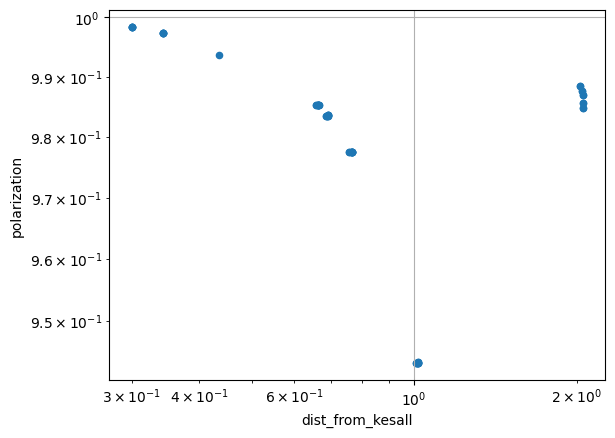

In [33]:
results_df.plot.scatter(x='dist_from_kesall', y='polarization', grid=True, loglog=True)

In [91]:
best_res = results_df.loc[results_df.dist_from_kesall.argmin()]
best_res

s_min                 0.005623
s_max                20.000000
big_gamma             5.200000
small_gamma           4.000000
dist_from_kesall      0.000742
dist_between_spec     0.002264
Name: 55, dtype: float64

## Plot the best results

In [5]:
best_res = {'s_min': 0.001, 's_max': 50.0, 'big_gamma': 3, 'small_gamma': 3.8}

In [8]:
spectrum

array([  300.        ,   490.39446611,   801.62244131,  1310.3706971 ,
        2141.99512805,  3501.40852412,  5723.57121277,  9356.02549714,
       15293.81042868, 25000.        ])

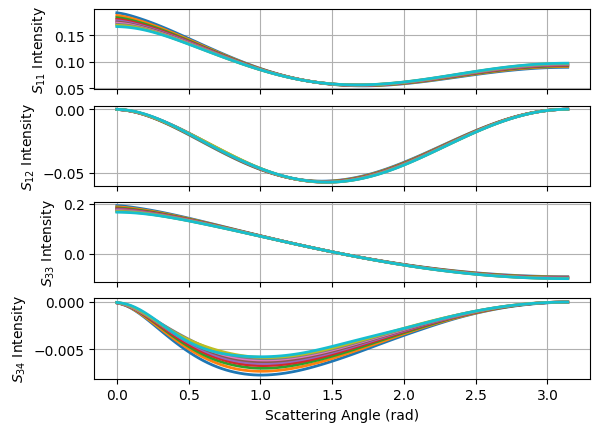

In [11]:
# recreate best results model and plot (full spectrum)
psm = ParticleSizeModel(s_min=best_res['s_min'], s_max=best_res['s_max'], big_gamma=best_res['big_gamma'], small_gamma=best_res['small_gamma'])  # create a particle size model
mie = MieScatteringModel.train(spectrum, particle_size=psm)
mie_scatt = mie(spectrum, theta)

# plot the Mueller matrix elements
plot_mueller_matrix_elems(theta, mie_scatt[:, :, 0, 0], mie_scatt[:, :, 0, 1],
                          mie_scatt[:, :, 2, 2], mie_scatt[:, :, 2, 3], title='Mueller Matrix Elements in wide Spectrum')

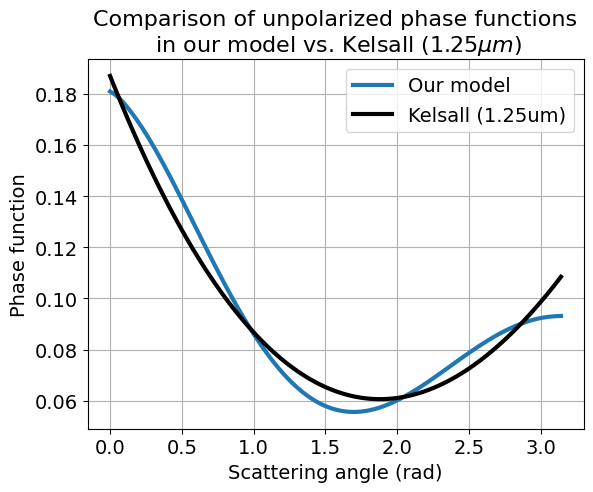

In [16]:
# Compare to Kelsall's model
mie_scatt = mie(1250, theta)
kelsall_125um = get_phase_function(theta, C1)

plt.figure()
plt.plot(theta, mie_scatt[:, :, 0, 0], lw=3, label='Our model')
plt.plot(theta, kelsall_125um, 'k', lw=3, label='Kelsall (1.25um)')
plt.title('Comparison of unpolarized phase functions\n in our model vs. Kelsall ($1.25\mu m$)', fontsize=16)
plt.xlabel('Scattering angle (rad)', fontsize=14)
plt.ylabel('Phase function', fontsize=14)
plt.grid()
plt.legend(prop={'size': 14})
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.savefig('outputs/mie_kelsall_model_compare.pdf', format='pdf')
plt.show()

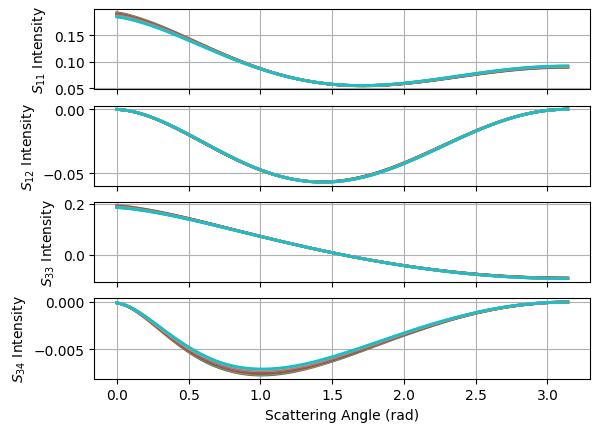

In [9]:
# Display out model in the White Light spectrum
spectrum_wl = np.logspace(np.log10(300), np.log10(700), 10)  # white light wavelength in nm
psm = ParticleSizeModel(s_min=best_res['s_min'], s_max=best_res['s_max'], big_gamma=best_res['big_gamma'], small_gamma=best_res['small_gamma'])  # create a particle size model
mie = MieScatteringModel.train(spectrum_wl, particle_size=psm)
mie_scatt = mie(spectrum_wl, theta)

# plot the Mueller matrix elements
plot_mueller_matrix_elems(theta, mie_scatt[:, :, 0, 0], mie_scatt[:, :, 0, 1],
                          mie_scatt[:, :, 2, 2], mie_scatt[:, :, 2, 3], title='Mueller Matrix Elements in the Visible Spectrum')

In [100]:
# save the new Mie model
from zodipol.zodipol.zodipol import MIE_MODEL_DEFAULT_PATH
mie.save(MIE_MODEL_DEFAULT_PATH)
print(MIE_MODEL_DEFAULT_PATH)

saved_models/white_light_mie_model.npz
